# Repeat On Circuit(RUS) Tutorial (Only available on OpenQASM3 environ)

### 1. Circuit definition

In [95]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np

control = QuantumRegister(1, name="control")
target = QuantumRegister(1, name="target")
theta1 = np.pi / 6
theta2 = np.pi / 4
theta3 = np.pi / 3
mid_measure = ClassicalRegister(1, name="mid")
final_measure = ClassicalRegister(1, name="final")

base = QuantumCircuit(control, target, mid_measure, final_measure)

## 2. Make RUS Circuit

### 2-1. A single trial of the probabalistic gate

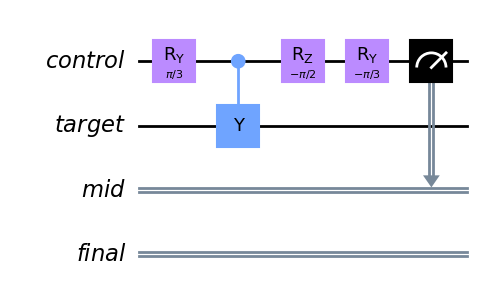

In [96]:
def trial(circuit, target, control, theta, measure):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.ry(2*theta, control)
    circuit.cy(control, target)
    circuit.rz(-np.pi/2, control)
    circuit.ry(-2*theta, control)
    circuit.measure(control, measure)


example = base.copy_empty_like()
trial(example, target, control, theta1, mid_measure)
example.draw("mpl", cregbundle=False)

### 2-2. Add Reset Control Ciruit

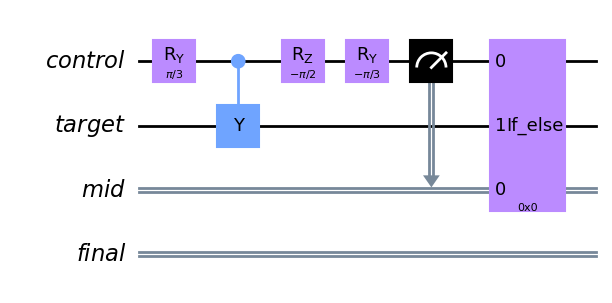

In [97]:
def repeat_parts(circuit, control, measure):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measure, 0)) as else_:
        pass
    with else_:
        # Reset the control and target.
        circuit.x(control)
        circuit.ry(-np.pi/2, target)
        # Then repeat the trial.
        trial(circuit, target, control, theta1, mid_measure)

repeat_parts(example, control, mid_measure)
example.draw("mpl", cregbundle=False)

### 2-3. Repeat Circuit Until Success!

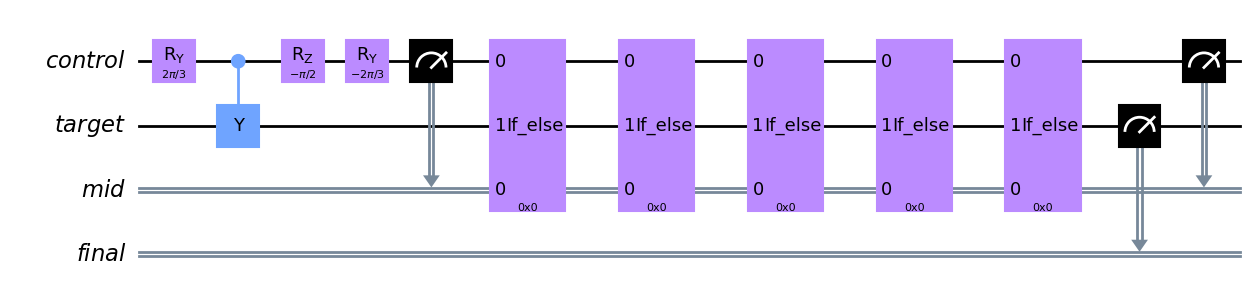

In [108]:
# set max trials
max_trials = 6

# Create a clean circuit with the same structure (bits, registers, etc)
# as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls
# are guaranteed to start in the |0> state.
trial(circuit, target, control, theta3, mid_measure)

# Manually add the rest of the trials.  In the future, we will be
# able to use a dynamic `while` loop to do this, but for now, we
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    repeat_parts(circuit, control, mid_measure)

# We need to measure the control qubits again to ensure we
# get their final results; this is a hardware limitation.
circuit.measure(control, mid_measure)

# Finally, let's measure our target, to check that we're
# getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw("mpl", cregbundle=False)

## 3. Run Circuit on Backend

### 3-1. Get Backend

In [105]:
from qiskit_ibm_provider import IBMProvider, least_busy

provider = IBMProvider()

backends_info = {
    'ibm_canberra' : "q-info-hackathon/team-21/main",
    'ibmq_mumbai' : "ibm-q-skku/hackathon-2023/hackathon",
    'ibm_hanoi' : 'ibm-q-skku/hackathon-2023/hackathon'
    }

backend_name, instance = list(backends_info.items())[0]

backend = provider.get_backend(backend_name, instance=instance)
print(f"Using {backend.name}")

Using ibm_canberra


### 3-2. Transpile

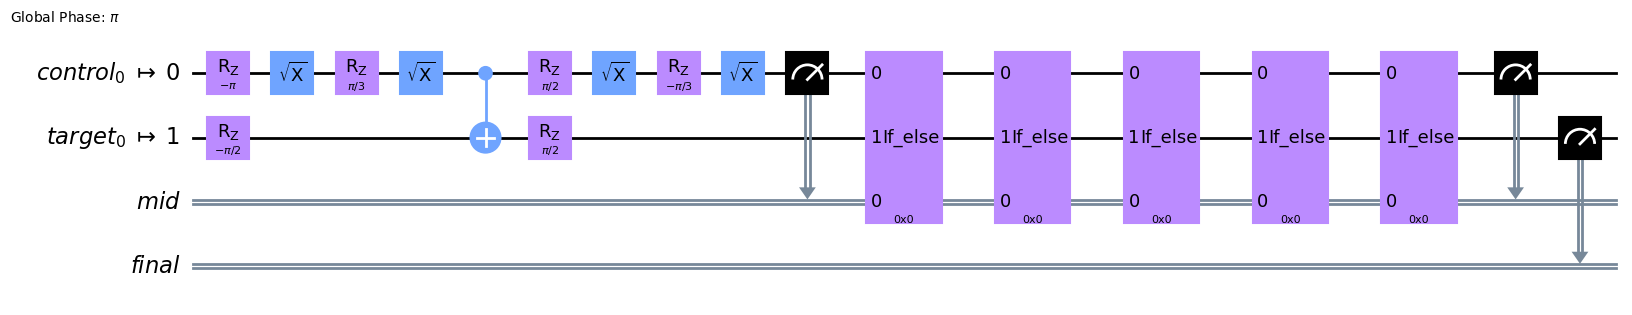

In [111]:
from qiskit import transpile

built = transpile(circuit, backend)
built.draw("mpl", cregbundle=False, idle_wires=False)

### 3-3. Aer Simulation

#### 3-3-1. Theoretical expectation value

In [50]:
Success_prob = 1 - (1 - 5 / 8) ** max_trials

print(f'Success probability (theory) : {Success_prob}')

Success probability (theory) : 0.947265625


#### 3-3-2. Aer Simulation Result

In [110]:
from qiskit_aer import AerSimulator

sim = AerSimulator(method="statevector")
simulator_result = sim.run(built, shots=3000).result()
simulator_counts = simulator_result.get_counts()

print(f'Simulation result : {simulator_counts}')

import collections

def marginalize_successes(counts):
    """Split the full output `counts` dictionary
    into two separate dictionaries, marginalizing
    the results to leave only the target qubit's
    state."""
    successes = collections.defaultdict(int)
    failures = collections.defaultdict(int)

    for key, value in counts.items():
        if key.endswith("00"):
            successes[key[0]] += value
        else:
            failures[key[0]] += value

    return successes, failures


sim_successes, sim_failures = marginalize_successes(simulator_counts)

# What percentage of the results were successful?
print(f"Success probability (simulation) : {sum(sim_successes.values()) / sum(simulator_counts.values())}")

Simulation result : {'1 1': 3, '0 1': 10, '1 0': 2440, '0 0': 547}
Success probability (simulation) : 0.0


### 3-3. Run on Backend

#### 3-3-1. Run job

In [44]:
# Recall that `built = transpile(circuit, backend)`.
job = backend.run(built, dynamic=True)
job.job_id()

'ci9pvgs8lm446nqgjkc0'

In [94]:
hardware_counts = job.result().get_counts()
hardware_counts

IBMJobFailureError: "Job failed: 'Internal Error while executing OpenQASM 3 circuit.'"

#### 3-3-2. Analyze backend result

In [23]:
hw_successes, hw_failures = marginalize_successes(hardware_counts)

expected_successes = 1 - (1 - 5 / 8) ** max_trials
actual_successes = sum(hw_successes.values()) / sum(hardware_counts.values())
print(
    f"Expected success rate {expected_successes:5.3f}.  Actual rate {actual_successes:5.3f}."
)

Expected success rate 0.859.  Actual rate 0.618.


In [24]:
actual_probability = hw_successes["1"] / sum(hw_successes.values())
print(f"Expected |1> probability: 0.2.  Actual probability {actual_probability:5.3f}.")

Expected |1> probability: 0.2.  Actual probability 0.407.
